**NOTICE:**

The predict value is not accurate unless the confirm/deaths/recorverd huge increasment day duration > 2-3 weeks, so please not be scared and keep patient. Figures are for reference only.

**NOTE:**
* I copied the data collection part from this notebook : https://www.kaggle.com/alixmartin/covid-19-predictions
* Use the github data to predict newest case https://github.com/CSSEGISandData/COVID-19
* Can predict the province
* Full world predict (With China Data / Without China Data)
* More pretty code
* I will update the predict every day
* Can predict deaths / recovered / active

**Please vote if you like!**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [2]:
#check the old format
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('').drop(['Lat', 'Long'], axis=1)
death_table = death_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('').drop(['Lat', 'Long'], axis=1)
recovered_table = recovered_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('').drop(['Lat', 'Long'], axis=1)

full_table = confirmed_table.merge(death_table).merge(recovered_table)

full_table['Date'] = pd.to_datetime(full_table['Date'])
full_table

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered
0,,Afghanistan,2020-01-22,0,0,0
1,,Albania,2020-01-22,0,0,0
2,,Algeria,2020-01-22,0,0,0
3,,Andorra,2020-01-22,0,0,0
4,,Angola,2020-01-22,0,0,0
...,...,...,...,...,...,...
16179,,Burma,2020-03-29,10,0,0
16180,Anguilla,United Kingdom,2020-03-29,2,0,0
16181,British Virgin Islands,United Kingdom,2020-03-29,2,0,0
16182,Turks and Caicos Islands,United Kingdom,2020-03-29,4,0,0


### Cleaning Data

In [3]:
# cases 
#cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
# full_table[cases] = full_table[cases].fillna(0)
full_table

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered,Active
0,,Afghanistan,2020-01-22,0,0,0,0
1,,Albania,2020-01-22,0,0,0,0
2,,Algeria,2020-01-22,0,0,0,0
3,,Andorra,2020-01-22,0,0,0,0
4,,Angola,2020-01-22,0,0,0,0
...,...,...,...,...,...,...,...
16179,,Burma,2020-03-29,10,0,0,10
16180,Anguilla,United Kingdom,2020-03-29,2,0,0,2
16181,British Virgin Islands,United Kingdom,2020-03-29,2,0,0,2
16182,Turks and Caicos Islands,United Kingdom,2020-03-29,4,0,0,4


In [4]:
def get_time_series(country):
    # for some countries, data is spread over several Provinces
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed', 'Deaths', 'Recovered', 'Active'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]


def get_time_series_province(province):
    # for some countries, data is spread over several Provinces
    df = full_table[(full_table['Province/State'] == province)]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]

data looks a bit dirty, we might get an overly optimistic prediction because the last number is not the final one for instance.

The model is quite sensitive to this as it has only a handful of points to infer the dynamics from.


In [5]:
country = 'China'
df = get_time_series(country)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail(10)

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-03-20,81250,3253,71266,6731
2020-03-21,81305,3259,71857,6189
2020-03-22,81435,3274,72362,5799
2020-03-23,81498,3274,72814,5410
2020-03-24,81591,3281,73280,5030
2020-03-25,81661,3285,73773,4603
2020-03-26,81782,3291,74181,4310
2020-03-27,81897,3296,74720,3881
2020-03-28,81999,3299,75100,3600


I will use a model from a marketing paper by Emmanuelle Le Nagard and Alexandre Steyer, that attempts to reflect the social structure of a diffusion process. Their application was the diffusion of innovations, not epidemics. However, there are commonalities in both domains, as the number of contacts each infected person / innovation adopter has seems relevant. It also has the added benefit to allow fitting parameters to the beginning of a time series.

paper is available (in French) [here](https://www.jstor.org/stable/40588987)

The model is also sensitive to when we define the origin of time for the epidemic process. Here, I just took the first point of the time series available, but adding a lag parameter could be attempted.

In [6]:
import math
def model_with_lag(N, a, alpha, lag, t):
    # we enforce N, a and alpha to be positive numbers using min and max functions
    lag = min(max(lag, -100), 100) # lag must be less than +/- 100 days 
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * (t - lag))) ** max(alpha, 0)

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [7]:
model_index = 0

def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, model_index]) ** 2
#         r += (math.log(1 + model(N, a, alpha, t)) - math.log(1 + df.iloc[t, 0])) ** 2 
#         r += (model_with_lag(N, a, alpha, lag, t) - df.iloc[t, 0]) ** 2
#         print(model(N, a, alpha, t), df.iloc[t, 0])
    return math.sqrt(r) 

we need to explore the 3d parameter space to find a minimum, using gradient descent. There are a number of algorithms to do that in scipy.optimize, I stopped at the first one that seemed to work. Generalized Reduced Gradient as in Excel solver also works.

In [8]:
import numpy as np
from scipy.optimize import minimize
use_lag_model = False
if use_lag_model:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15, 0]), method='Nelder-Mead', tol=1e-5).x
else:
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
opt_deaths

array([1.62673482e+05, 1.93683936e-04, 8.58728837e-01])

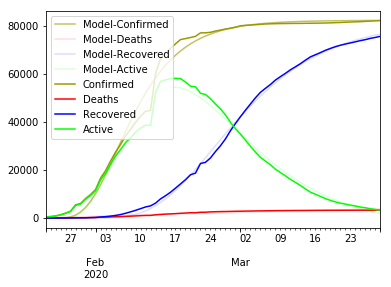

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

model_sim['Model-Active'] = model_sim['Model-Confirmed'] - model_sim['Model-Deaths'] - model_sim['Model-Recovered']
model_sim.loc[model_sim['Model-Active']<0,'Model-Active'] = 0
plot_color = ['#99990099', '#FF000022', '#0000FF22', '#00FF0022', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

pd.concat([model_sim, df], axis=1).plot(color = plot_color)
plt.show()

let's extend the prediction curve

China COVID-19 Prediction


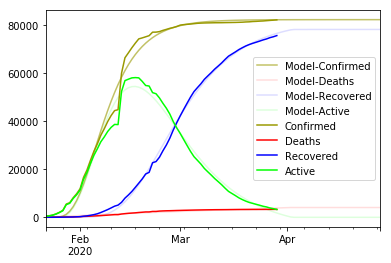

In [10]:
import datetime
start_date = df.index[0]
n_days = len(df) + 30
extended_model_x = []
last_row = []

isValid = True
last_death_rate = 0

for t in range(n_days):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
    
    #if deaths + recovered > confirmed or deaths rate > 12%, maybe not valid
    if (t > len(df)):
        last_row = extended_model_x[-1]
        if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.12):
            if (isValid):
                last_row2 = extended_model_x[-2]
                last_death_rate = last_row2[2]/last_row2[1]
                isValid = False

        if (last_row[2] > last_row[1]*0.05):
            last_row[2] = last_row[1]*last_death_rate
            
        if (last_row[2] + last_row[3] > last_row[1]):
            last_row[2] = last_row[1]*last_death_rate
            last_row[3] = last_row[1]*(1-last_death_rate)

extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)

extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']
extended_model_sim['Model-Active'] = extended_model_sim['Model-Confirmed'] - extended_model_sim['Model-Deaths'] - extended_model_sim['Model-Recovered']
extended_model_sim.loc[extended_model_sim['Model-Active']<0,'Model-Active'] = 0

plot_color = ['#99990099', '#FF000022', '#0000FF22', '#00FF0022', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

pd.concat([extended_model_sim, df], axis=1).plot(color = plot_color)
print('China COVID-19 Prediction')
plt.show()

let's display predictions for future weeks

In [11]:
df.tail()

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-03-25,81661,3285,73773,4603
2020-03-26,81782,3291,74181,4310
2020-03-27,81897,3296,74720,3881
2020-03-28,81999,3299,75100,3600
2020-03-29,82122,3304,75582,3236


In [12]:
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, extended_model_sim], axis=1)
concat_df[concat_df.index.day % 3 == 0]

,Confirmed,Deaths,Recovered,Active,Model-Confirmed,Model-Deaths,Model-Recovered,Model-Active
2020-01-24,920,26,36,858,2,191,0,0
2020-01-27,"2,877",82,58,"2,737",513,420,0,93
2020-01-30,"8,141",171,135,"7,835","4,450",628,1,"3,820"
2020-02-03,"19,716",425,614,"18,677","17,990",890,69,"17,031"
2020-02-06,"30,587",633,"1,477","28,477","31,461","1,077",428,"29,956"
2020-02-09,"39,829",905,"3,219","35,705","44,419","1,260","1,552","41,607"
2020-02-12,"44,759","1,117","5,082","38,560","55,226","1,437","3,973","49,816"
2020-02-15,"68,413","1,663","9,298","57,452","63,488","1,612","7,996","53,880"
2020-02-18,"74,211","2,003","14,206","58,002","69,468","1,783","13,555","54,130"
2020-02-21,"75,550","2,238","18,704","54,608","73,648","1,951","20,270","51,427"


now let's compare the dynamic in different countries

In [13]:
def display_fit(df, opt_confirmed, opt_deaths, opt_recovered, ax):
    model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = model_x[-1]
            if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
                    
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                
            if (last_row[2] + last_row[3] > last_row[1]):
                last_row[2] = last_row[1]*last_death_rate
                last_row[3] = last_row[1]*(1-last_death_rate)
                
                
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

    model_sim['Model-Active'] = model_sim['Model-Confirmed'] - model_sim['Model-Deaths'] - model_sim['Model-Recovered']
    model_sim.loc[model_sim['Model-Active']<0,'Model-Active'] = 0
    plot_color = ['#99990099', '#FF000022', '#0000FF22', '#00FF0022', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)

def display_extended_curve(df, opt_confirmed, opt_deaths, opt_recovered, ax):
    start_date = df.index[0]
    n_days = len(df) + 40
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                    
            if (last_row[2] + last_row[3] > last_row[1]):
                last_row[2] = last_row[1]*last_death_rate
                last_row[3] = last_row[1]*(1-last_death_rate)
                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

    extended_model_sim['Model-Active'] = extended_model_sim['Model-Confirmed'] - extended_model_sim['Model-Deaths'] - extended_model_sim['Model-Recovered']
    
    extended_model_sim.loc[extended_model_sim['Model-Active']<0,'Model-Active'] = 0
    plot_color = ['#99990099', '#FF000022', '#0000FF22', '#00FF0022', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)


def opt_display_model(df, stats):
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    global model_index
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    if min(opt_confirmed) > 0:
        stats.append([country, *opt_confirmed, *opt_deaths, *opt_recovered])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit(df, opt_confirmed, opt_deaths, opt_recovered, ax1)
        ax2 = plt.subplot(222)
        display_extended_curve(df, opt_confirmed, opt_deaths, opt_recovered, ax2)
        plt.show()

* **Predict World (With China Data) **

World COVID-19 Prediction (With China Data)


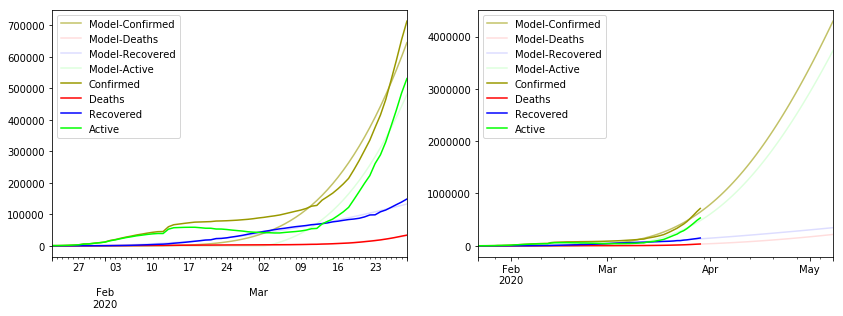

In [14]:
stats = []

df = full_table[['Province/State','Country/Region', 'Date', 'Confirmed', 'Deaths', 'Recovered', 'Active']].groupby('Date').sum()
print('World COVID-19 Prediction (With China Data)')
opt_display_model(df, stats)

* **Predict World (Without China Data) **

Maybe event worse if except china data!

World COVID-19 Prediction(Without China Data)


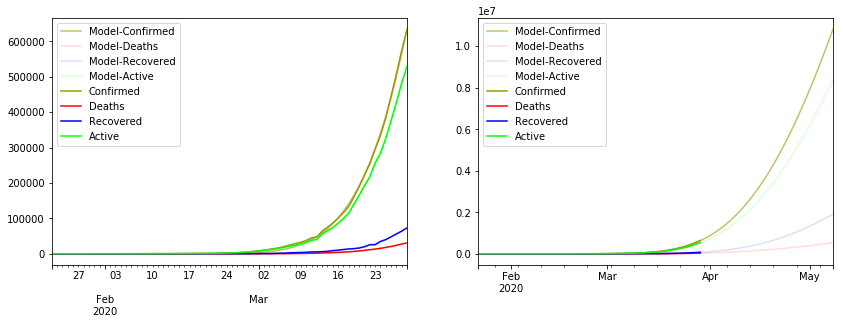

In [15]:
stats = []

df = full_table[full_table['Country/Region'] != 'China'][['Province/State','Country/Region', 'Date', 'Confirmed', 'Deaths', 'Recovered', 'Active']].groupby('Date').sum()
print('World COVID-19 Prediction(Without China Data)')
opt_display_model(df, stats)

**Predict by Province**

Hong Kong COVID-19 Prediction


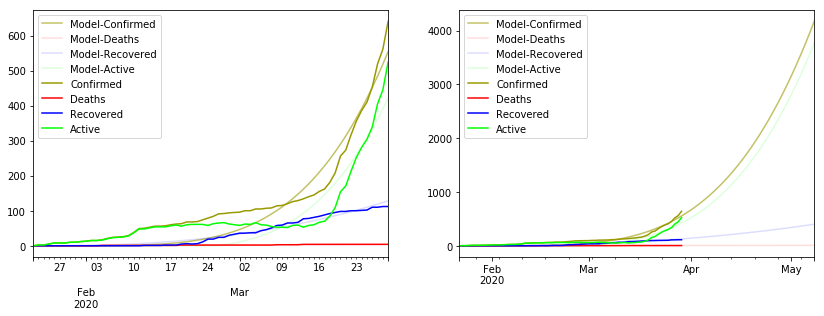

Shanghai COVID-19 Prediction


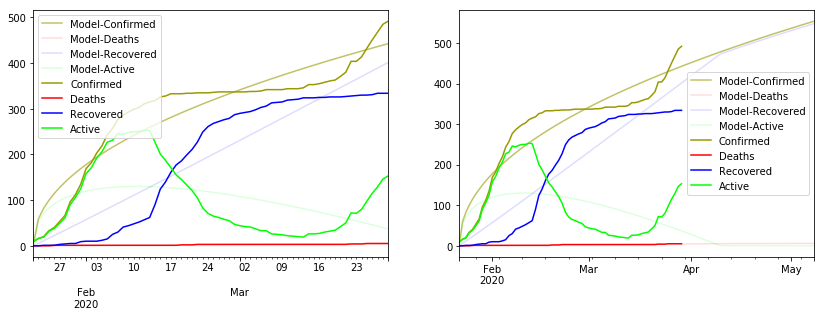

Anhui COVID-19 Prediction


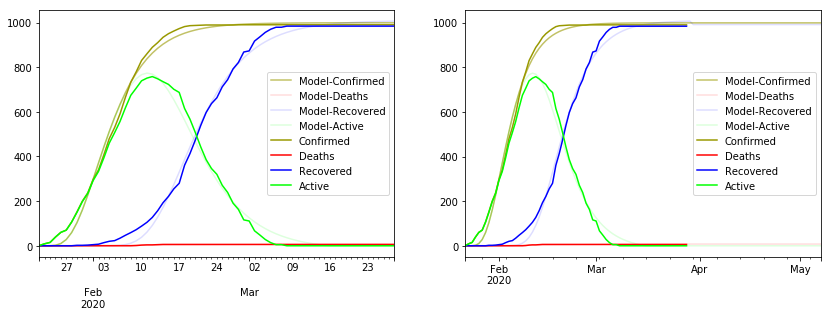

Hubei COVID-19 Prediction


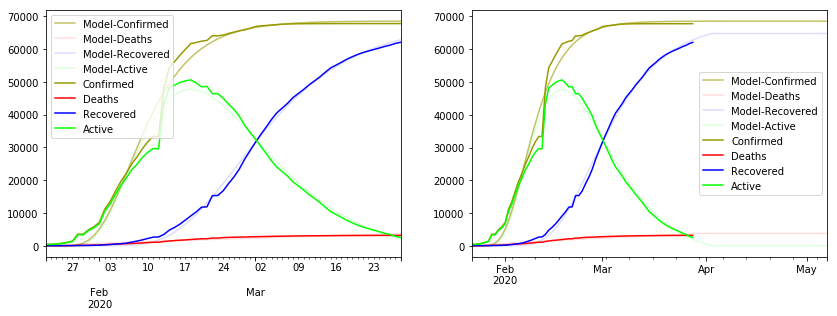

In [16]:
stats = []

# Province Specify
for Province in ['Hong Kong', 'Shanghai', 'Anhui', 'Hubei']:
    df = get_time_series_province(Province)
    print('{} COVID-19 Prediction'.format(Province))
    opt_display_model(df, stats)

**Predict by Specify Country**

Singapore COVID-19 Prediction


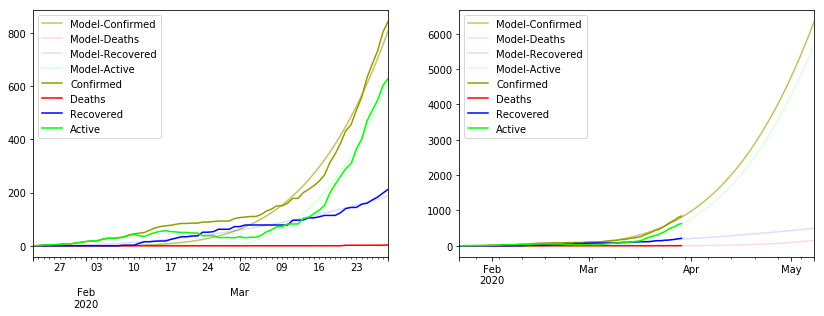

Russia COVID-19 Prediction


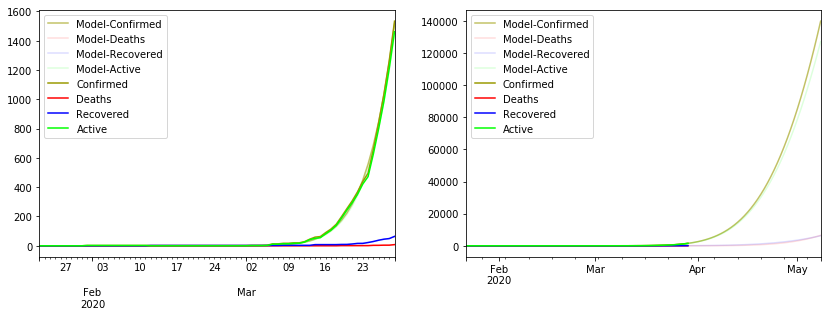

New Zealand COVID-19 Prediction


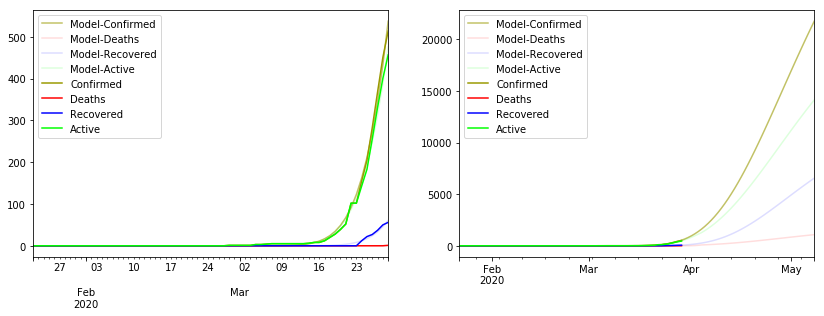

In [17]:
# Country Specify
stats = []
for country in ['Singapore', 'Russia', 'New Zealand']:
# for country in ['Sweden']:
    df = get_time_series(country)

    print('{} COVID-19 Prediction'.format(country))
    
    opt_display_model(df, stats)

**Predict all country greater than 1000**

Australia COVID-19 Prediction


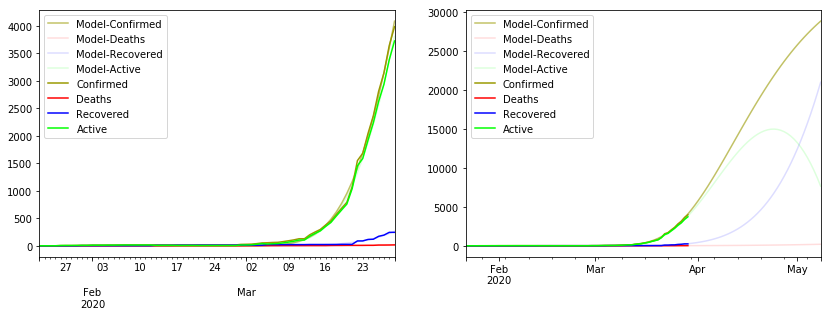

Austria COVID-19 Prediction


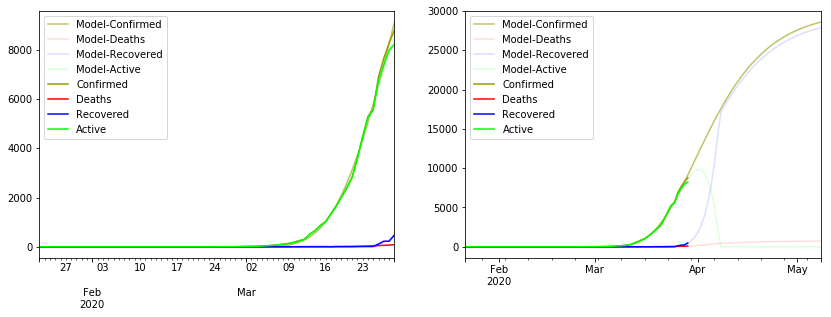

Belgium COVID-19 Prediction


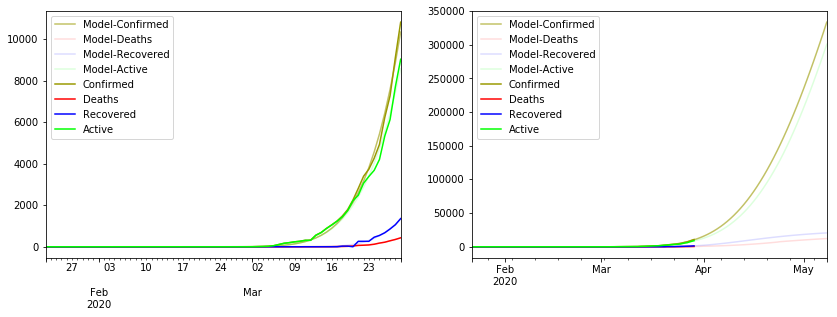

Brazil COVID-19 Prediction


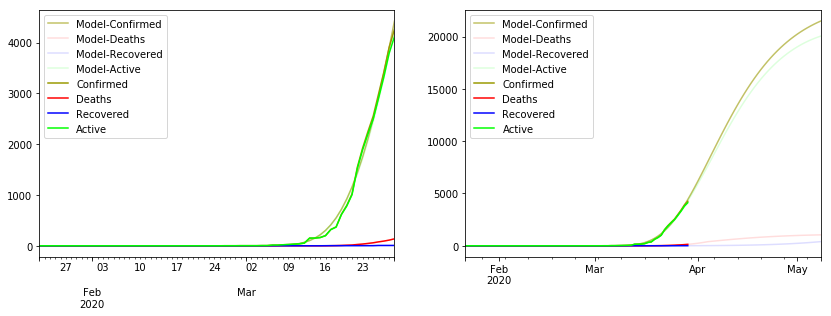

Chile COVID-19 Prediction


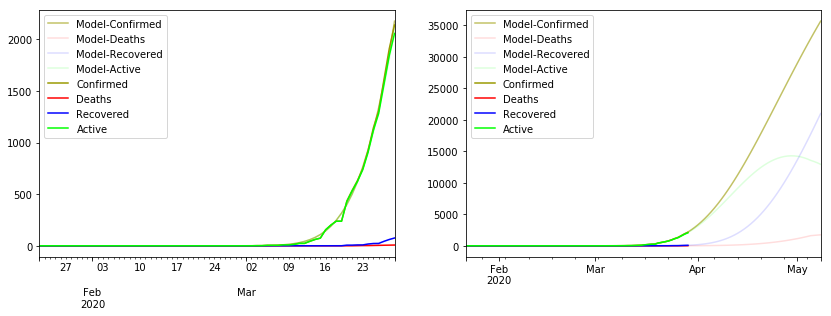

China COVID-19 Prediction


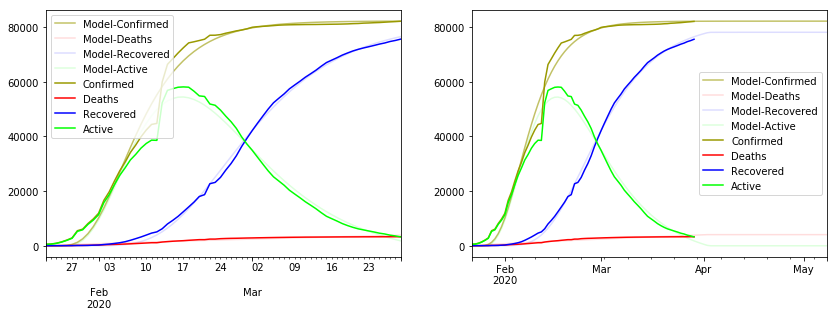

Czechia COVID-19 Prediction


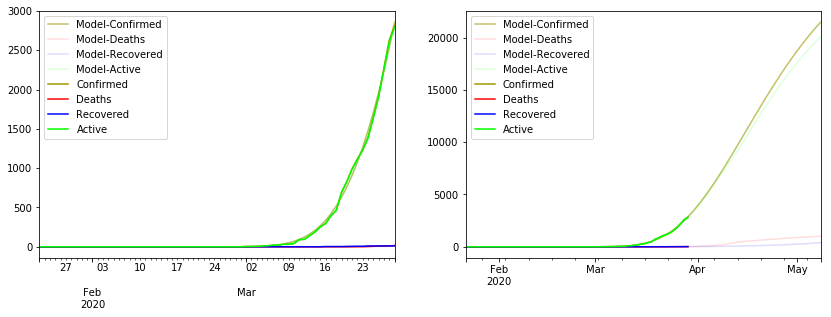

Denmark COVID-19 Prediction


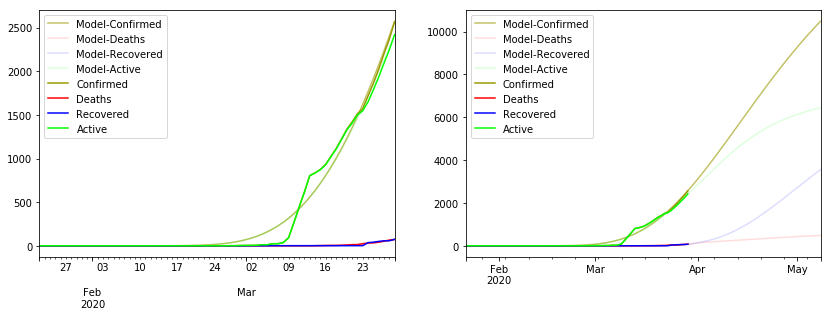

Ecuador COVID-19 Prediction


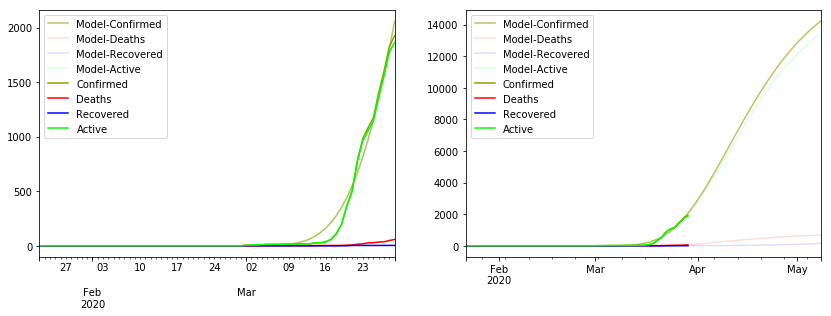

Finland COVID-19 Prediction


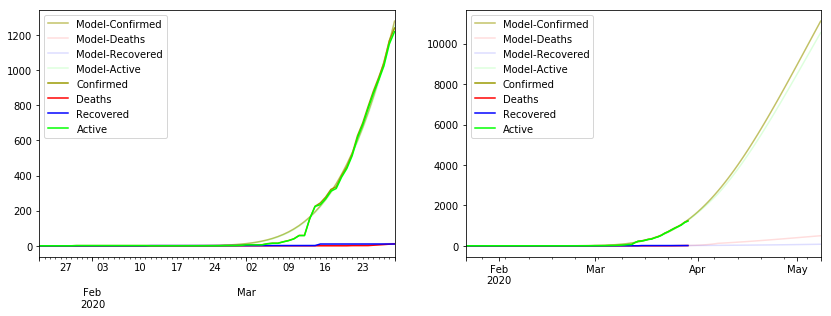

France COVID-19 Prediction


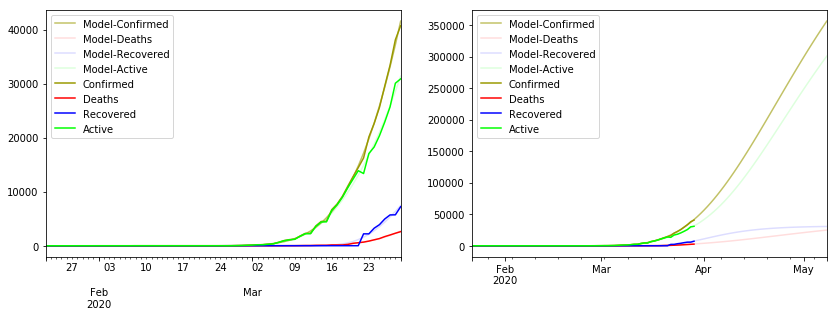

Germany COVID-19 Prediction


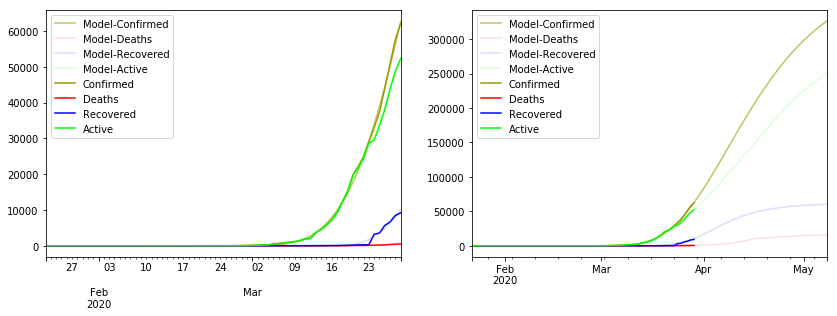

Greece COVID-19 Prediction


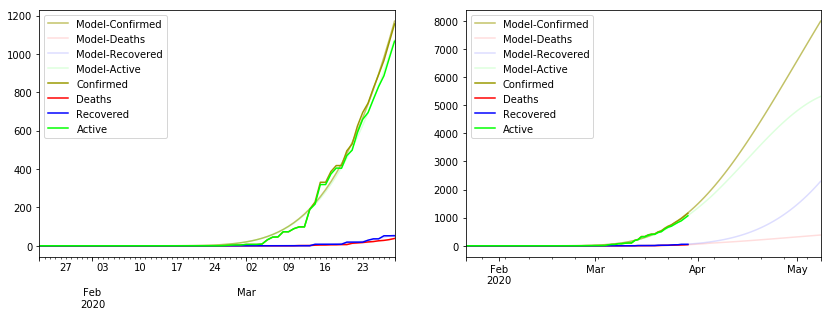

Iceland COVID-19 Prediction


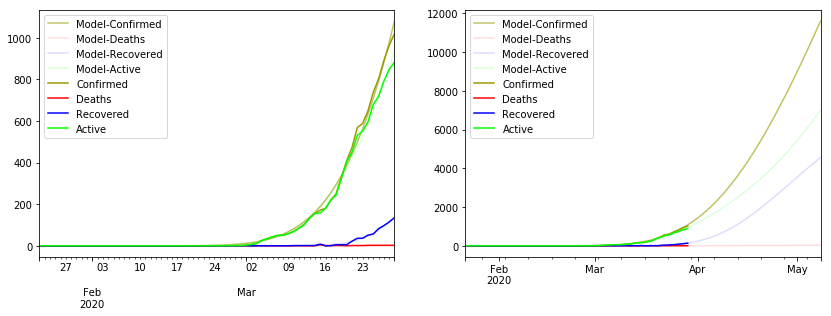

India COVID-19 Prediction


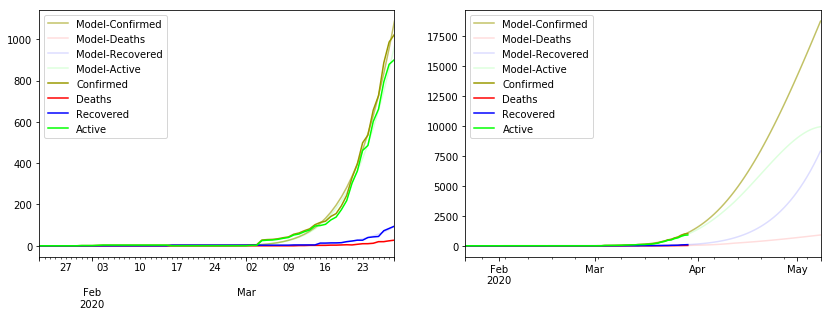

Indonesia COVID-19 Prediction


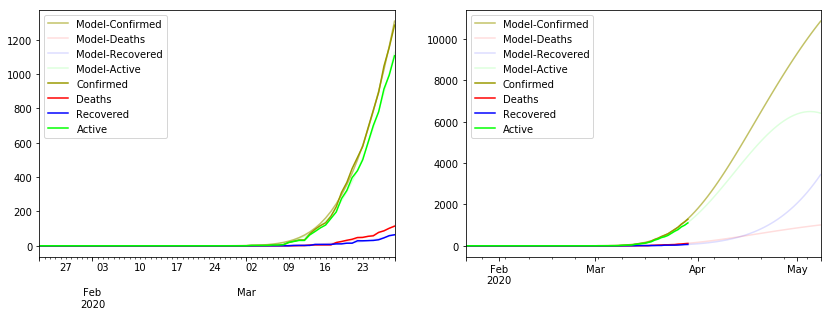

Iran COVID-19 Prediction


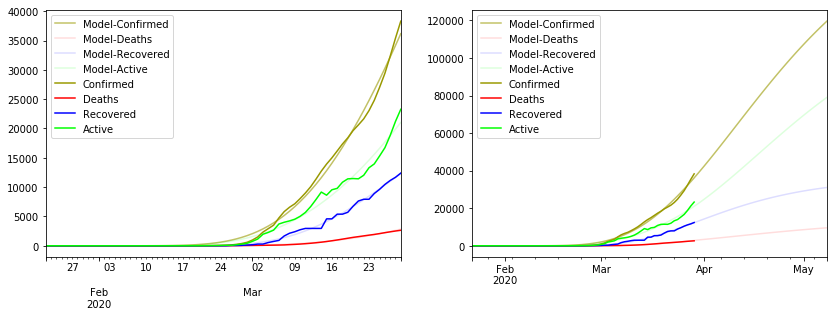

Ireland COVID-19 Prediction


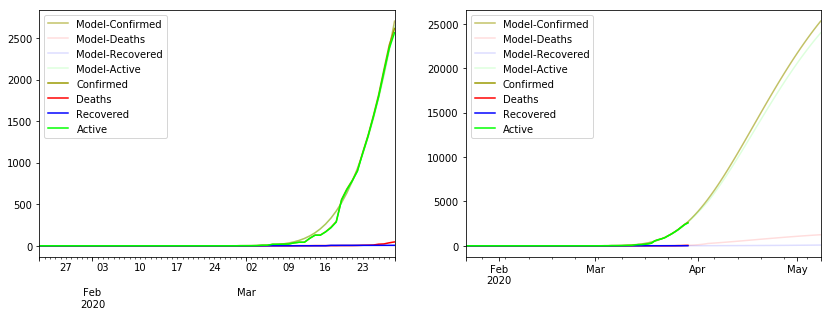

Israel COVID-19 Prediction


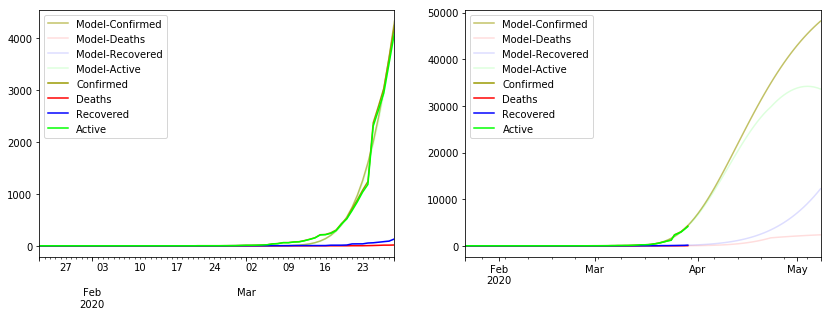

Italy COVID-19 Prediction


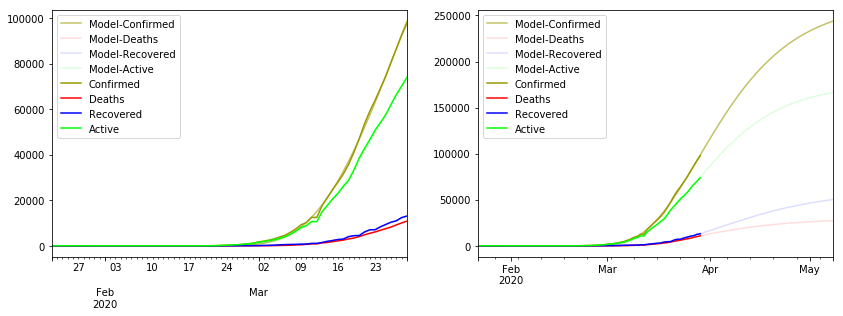

Japan COVID-19 Prediction


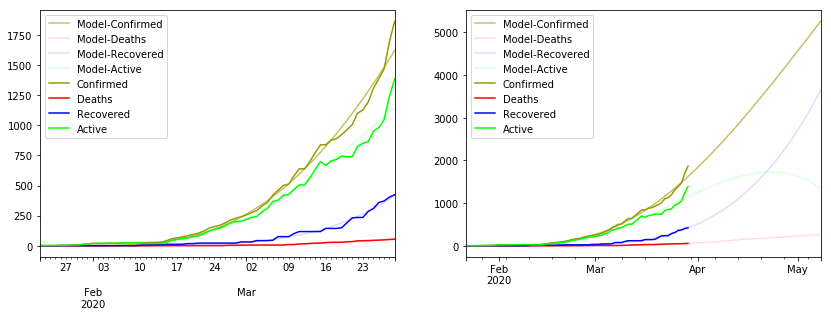

Korea, South COVID-19 Prediction


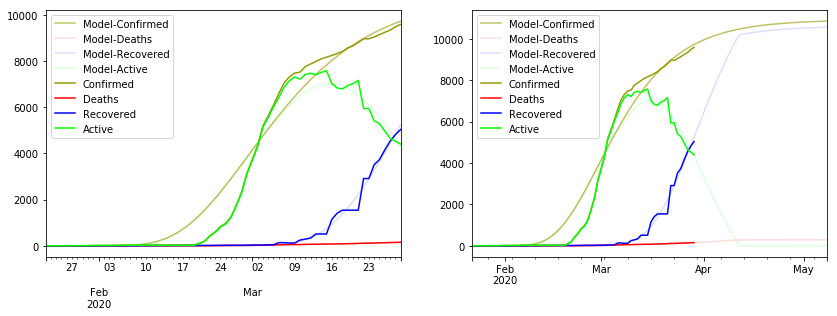

Luxembourg COVID-19 Prediction


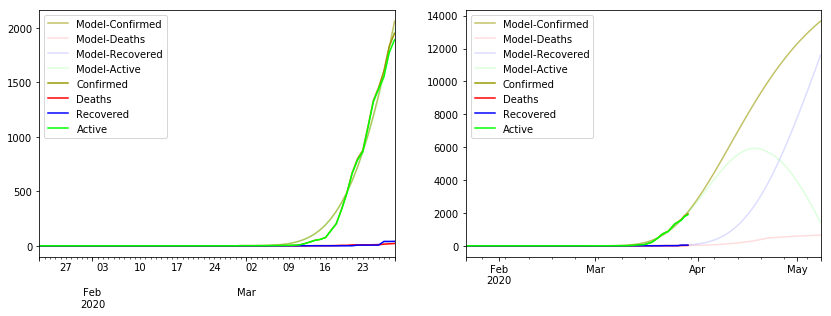

Malaysia COVID-19 Prediction


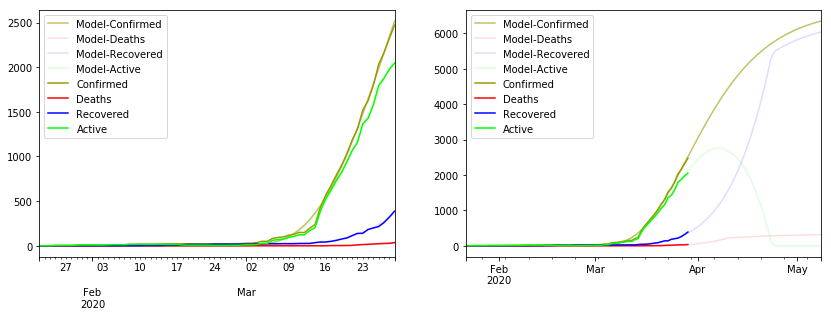

Netherlands COVID-19 Prediction


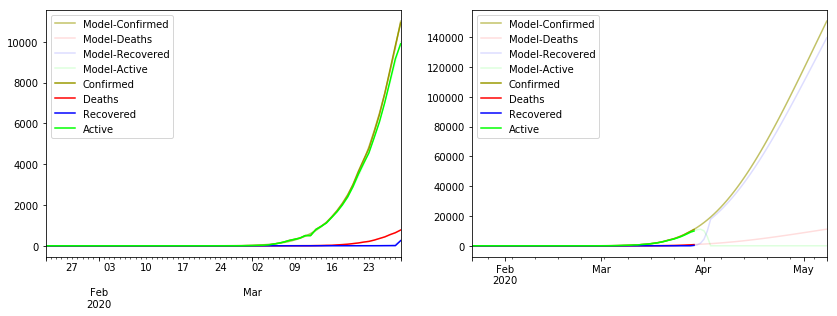

Norway COVID-19 Prediction


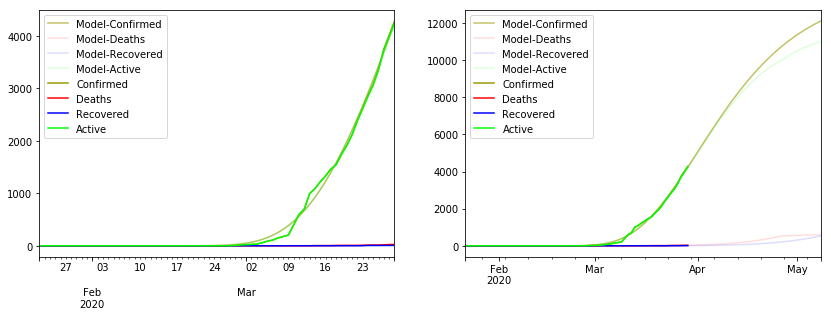

Pakistan COVID-19 Prediction


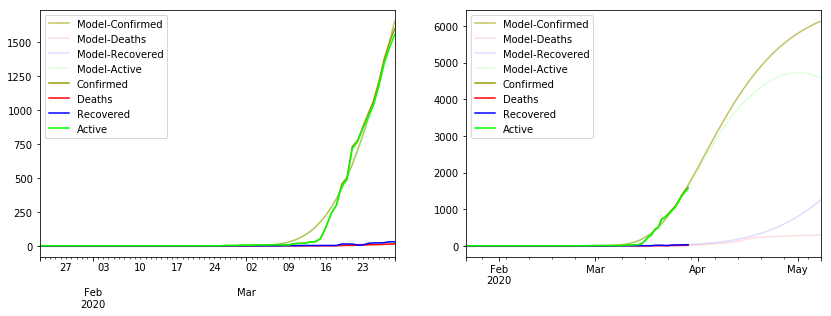

Philippines COVID-19 Prediction


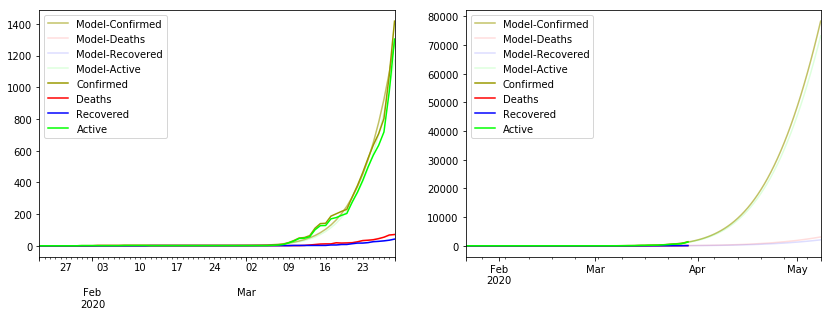

Poland COVID-19 Prediction


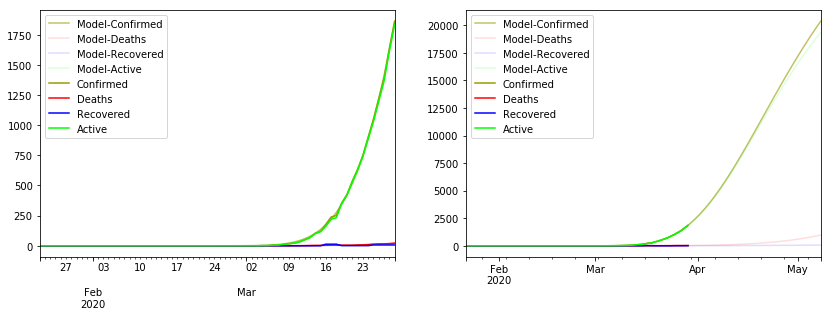

Portugal COVID-19 Prediction


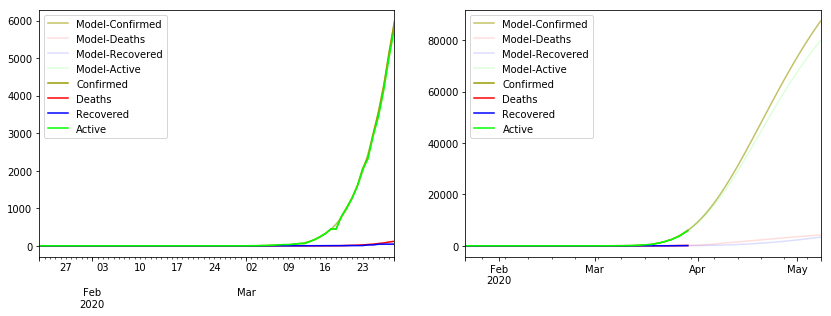

Romania COVID-19 Prediction


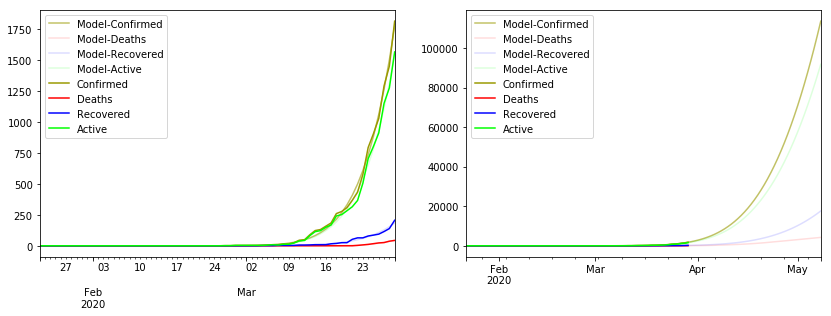

Russia COVID-19 Prediction


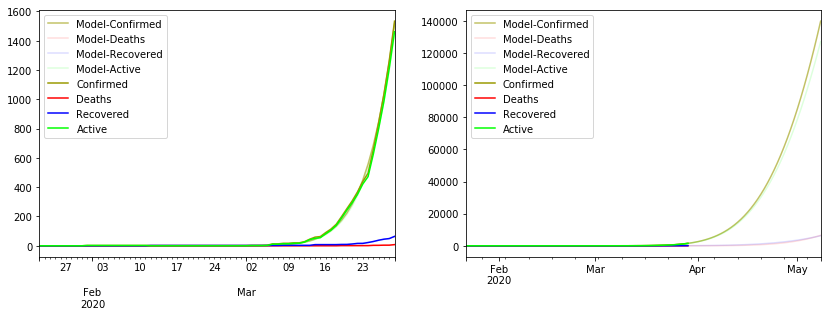

Saudi Arabia COVID-19 Prediction


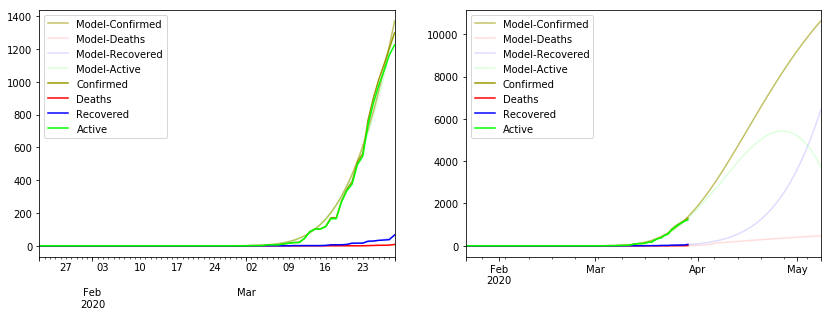

South Africa COVID-19 Prediction


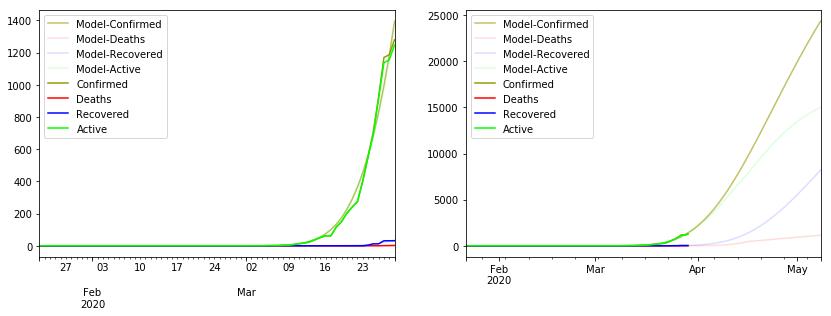

Spain COVID-19 Prediction


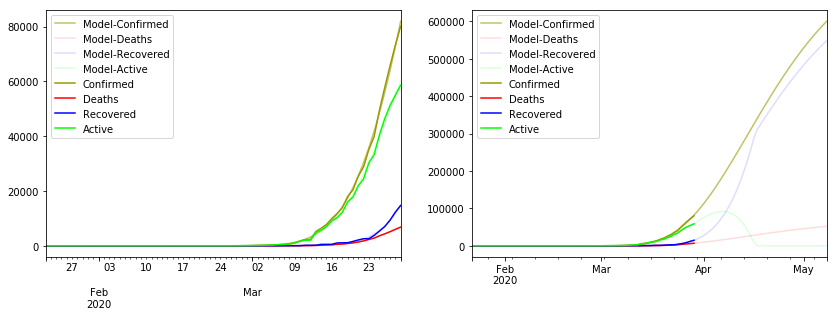

Sweden COVID-19 Prediction


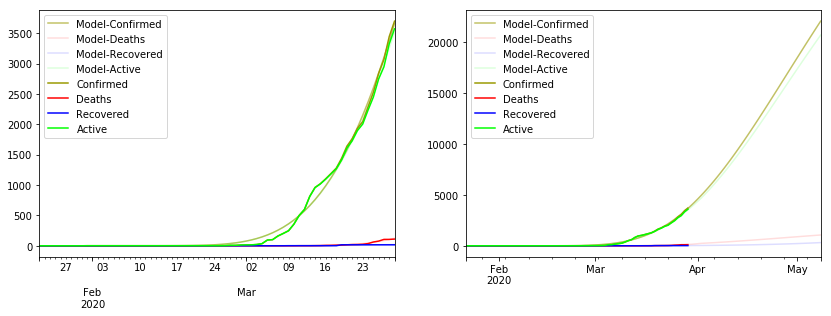

Switzerland COVID-19 Prediction


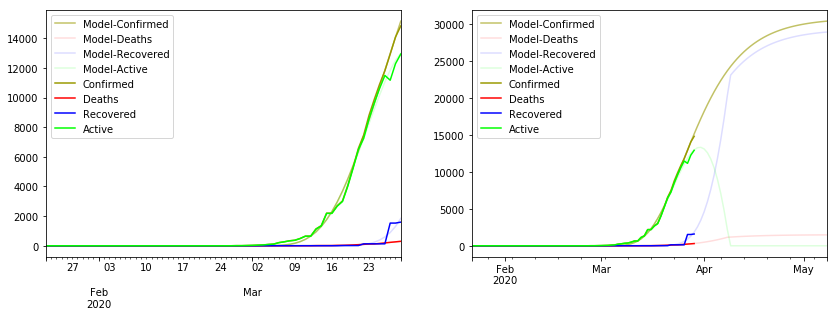

Thailand COVID-19 Prediction


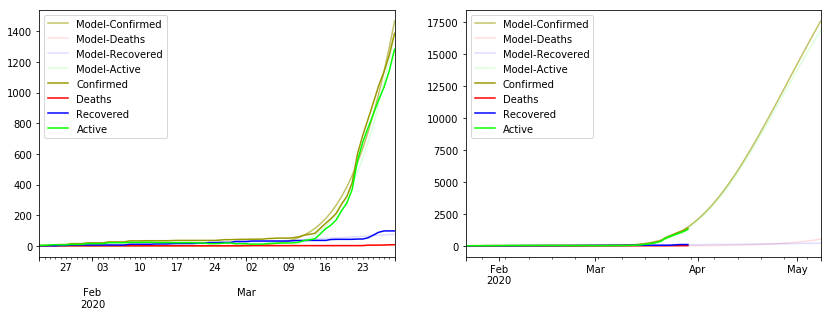

Turkey COVID-19 Prediction


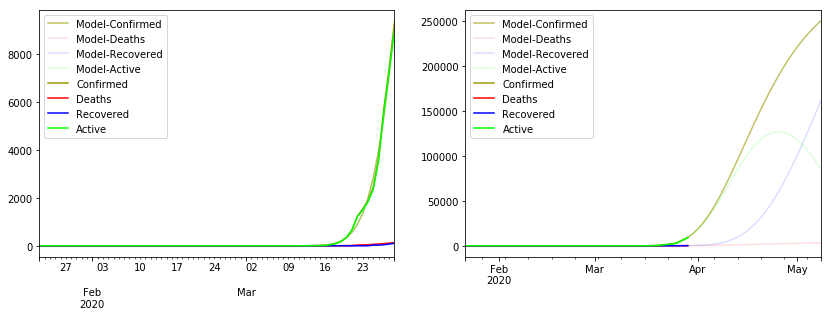

United Kingdom COVID-19 Prediction


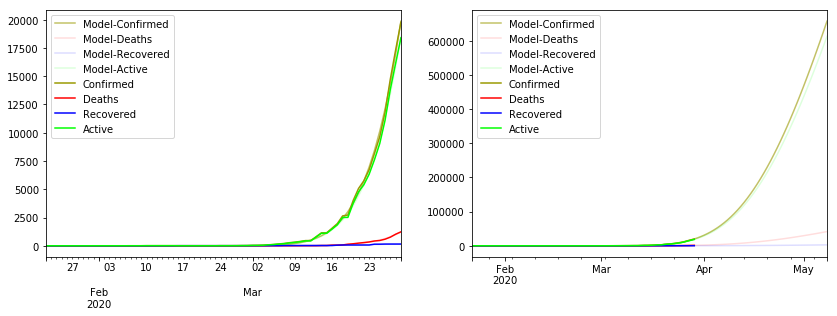

US COVID-19 Prediction


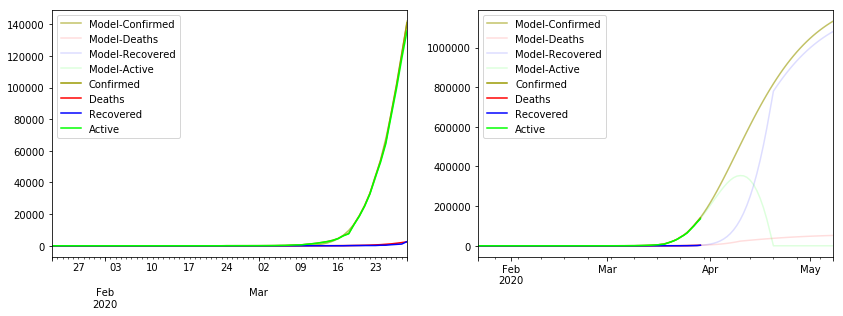

In [18]:
# All Country Confirmed Greater than 1000

stats = []
for country in full_table['Country/Region'].unique():
# for country in ['Sweden']:
    df = get_time_series(country)
    # only consider countries with at least 1000 cases (plus Sweden)
    if len(df) == 0 or (max(df['Confirmed']) < 1000): 
        continue
    print('{} COVID-19 Prediction'.format(country))
    opt_display_model(df, stats)

let's see if we can make some sense from the parameters

In [19]:

stats_df = pd.DataFrame(stats)
# stats_df.columns = ['country', 'N', 'a', 'alpha', 'lag']
stats_df.columns = ['country', 'Confirmed-N', 'Confirmed-a', 'Confirmed-alpha', 'Deaths-N', 'Deaths-a', 'Deaths-alpha', 'Recorved-N', 'Recorved-a', 'Recorved-alpha']
stats_df

,country,Confirmed-N,Confirmed-a,Confirmed-alpha,Deaths-N,Deaths-a,Deaths-alpha,Recorved-N,Recorved-a,Recorved-alpha
0,Australia,"36,425",0,91,"294,583",0,6,"953,776",0,20
1,Austria,"29,999",0,257,"14,626",0,73,"1,525,762",0,458
2,Belgium,"1,730,716",0,28,"18,537",0,144,"24,958",0,275
3,Brazil,"23,475",0,225,"8,619",0,96,"108,770",0,14
4,Chile,"63,311",0,61,"31,859",0,44,"73,506",0,110
5,China,"82,215",0,7,"162,673",0,1,"82,013",0,15
6,Czechia,"29,968",0,59,"105,233",0,62,"58,292",0,11
7,Denmark,"16,069",0,19,"38,263",0,37,"7,191",0,97
8,Ecuador,"17,254",0,115,"18,471",0,43,"41,103",0,11
9,Finland,"28,153",0,20,"65,522",0,77,"246,373",0,4


In [20]:
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:20,.4f}'.format
stats_df.astype({'Confirmed-N': 'int'}).sort_values(by='Confirmed-N', ascending=False)

,country,Confirmed-N,Confirmed-a,Confirmed-alpha,Deaths-N,Deaths-a,Deaths-alpha,Recorved-N,Recorved-a,Recorved-alpha
39,United Kingdom,2761098,0.0296,33.2831,"718,771.5164",0.0287,40.3180,"137,645.8750",0.0098,9.1353
30,Romania,2260561,0.0196,22.8200,"9,264.2473",0.0474,124.8051,"1,097,187.4121",0.0160,20.7513
31,Russia,2174763,0.0225,28.9492,"562,259.5092",0.0212,40.7037,"938,884.9328",0.0134,18.4466
27,Philippines,1737115,0.0188,21.6357,"418,795.3403",0.0110,13.2619,"98,423.4513",0.0146,16.4588
2,Belgium,1730715,0.0269,28.3193,"18,537.0911",0.0547,144.2132,"24,958.2979",0.0679,275.0439
40,US,1280907,0.0721,273.9715,"4,832,353.1917",0.0271,42.5846,"9,057,228.0589",0.0548,318.5145
34,Spain,811163,0.0504,66.0132,"51,786.5350",0.0712,236.8426,"8,609,599.6830",0.0334,56.4111
10,France,624223,0.0386,34.6043,"299,673.5259",0.0341,43.8825,"31,303.6496",0.1043,"1,558.0385"
11,Germany,391745,0.0573,84.3661,"596,042.8636",0.0283,43.0049,"61,331.9905",0.1119,"3,267.7615"
24,Netherlands,380416,0.0325,29.3701,"27,016.0627",0.0487,90.7965,"30,162,602.6220",0.0958,"7,208.5249"


N is the potential spread in the country if the dynamics since the beginning of the epidemy persist. One problem is that sometimes we're measuring the spread of testing rather than of the epidemy. For instance New York allegedly started tesing a lot of people, which might explain the current explosive dynamic in the US numbers.

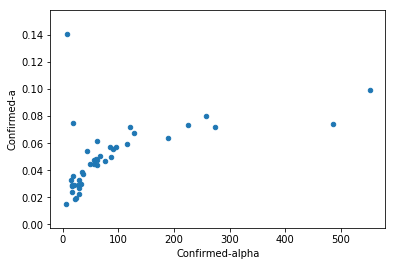

In [21]:
ax = stats_df.plot.scatter(x='Confirmed-alpha', y='Confirmed-a')
# ax.set_xlim([0, 100])
plt.show()